<a href="https://colab.research.google.com/github/amirgat/LearningMatter/blob/main/Replication_Dillavou_PRA_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the calculation done in Dillavou *et al.* PRA 2022

In this document we will aim to replicate the results presented in the paper *Demonstration of Decentralized Physics-Driven Learning*


## 1. Description of the Dillavou *et al.* PRA 2022

The abstract of Dillavou *et al.* PRA 2022

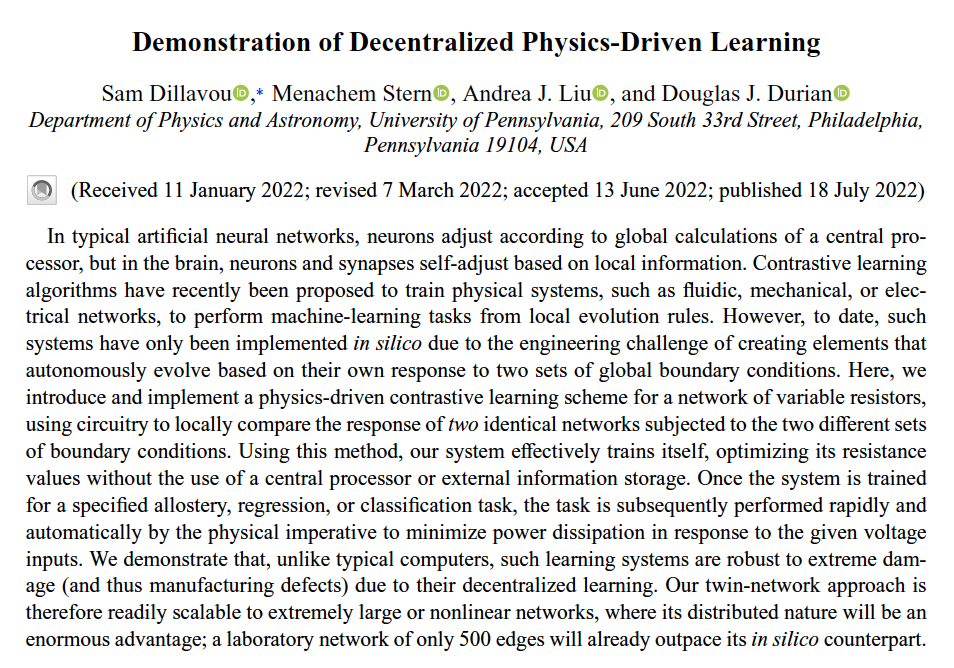

Equation #1

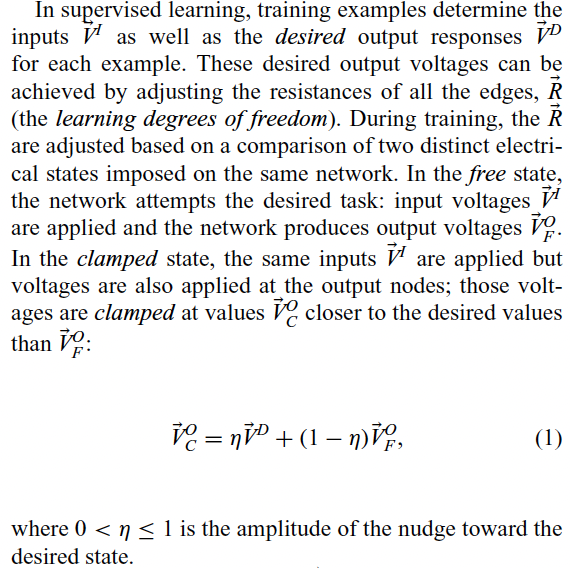

## 2. Preliminary codes

Importing all relevant packages

In [1]:
import numpy as np
import pandas as pd
import sympy as sy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.collections import LineCollection
import ipywidgets as widgets
from IPython.display import display
sy.init_printing()

General auxiliary functions

In [2]:
def pretty_print_array(name, arr):
    sy_arr = sy.Matrix(np.round(arr, 3))  # rounding to 3 decimal places
    print(f"Variable '{name}' of type '{type(arr)}':")
    sy_arr


## 3. Creating a list of random points

We define the required number of points, the distance between the points and the size of the rectangular.

In [13]:
# Maximum number of points to generate
num_points = 10

# Minimum distance between points
min_dist = 0.1

# The size of the board
x_min, x_max = -1, 1
y_min, y_max = -1, 1

Define a function to calculate Euclidean distance


Creating a function in which we add additional points until we reach the required number of points, or until we cannot add a point while keeping the requirement of minimal distance.

In [14]:
def generate_nodes(
    num_points, min_dist, x_range=(x_min, x_max), y_range=(y_min, y_max), seed=None
):
    # Initialize the random number generator with a seed if provided
    if seed is not None:
        np.random.seed(seed)

    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

    nodes_vec = []

    # Loop until we have required number of points
    for _ in range(num_points):
        # Try for a reasonable number of times to place a point
        for _ in range(1000):
            # Generate a random point within the specified range
            point = [np.random.uniform(*x_range), np.random.uniform(*y_range)]

            # Check if it's the first point or if the point is far enough from the other points
            if len(nodes_vec) == 0 or all(
                distance(point, p) >= min_dist for p in nodes_vec
            ):
                nodes_vec.append(point)
                break
        else:
            # We couldn't find a point that satisfied the distance requirement, so we stop generating
            print("Reached maximum density of points")
            break

    # Convert the list of points to a numpy array
    nodes = np.array(nodes_vec)
    return nodes

We run the generate_nodes functio to create the list of points

In [15]:
nodes_vec = generate_nodes(
    num_points, min_dist, x_range=(-1, 1), y_range=(-1, 1), seed=42
)

We plot the generated points

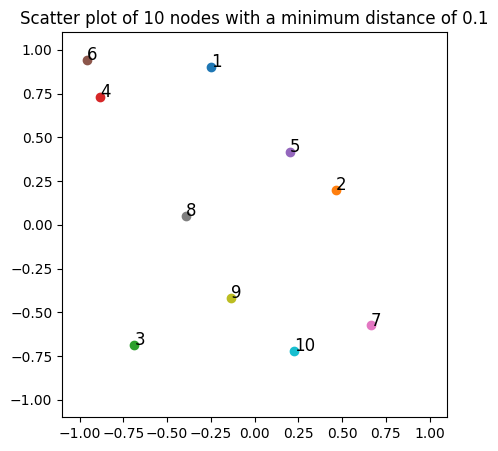

In [16]:
# Plotting
plt.figure(figsize=(5, 5))
for i, node in enumerate(nodes_vec):
    plt.scatter(*node, marker="o")  # plot point
    plt.text(
        node[0], node[1], str(i + 1), fontsize=12
    )  # label the point with the node number

plt.xlim([x_min - 0.1, x_max + 0.1])  # give a bit of padding to the plot
plt.ylim([y_min - 0.1, y_max + 0.1])  # give a bit of padding to the plot
plt.gca().set_aspect(
    "equal", adjustable="box"
)  # make sure the plot aspect ratio is 1:1
plt.title(
    f"Scatter plot of {len(nodes_vec)} nodes with a minimum distance of {min_dist}"
)
plt.show()

## 4. Defining connections between points & IC/BC

The propmt is:"*Now create a matrix of distances of each point relative to all other nodes. Name this matrix dist_matrix. Then use this dist_matrix to find all points in distance less then 0.2 of each point. Define another square matrix named connection_mat (with the same size as dist_matrix) in which is the the value of element dist_matrix[i,j] equal to 1 in point i is closed then 0.2  point j, or zero if not.*"

In [17]:
# Function to calculate distance matrix
def calc_distance_matrix(points):
    n = len(points)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist_matrix[i, j] = dist_matrix[j, i] = distance(points[i], points[j])
    return dist_matrix


# Compute the distance matrix
dist_matrix = calc_distance_matrix(nodes_vec)
sy_dist_matrix = sy.Matrix(np.round(dist_matrix, 3))
print("The distance matrix is")
sy_dist_matrix

The distance matrix is


⎡  0    1.003  1.648  0.655  0.664  0.709  1.738  0.863  1.324  1.69 ⎤
⎢                                                                    ⎥
⎢1.003    0    1.453  1.45   0.341  1.605  0.798  0.868  0.859  0.949⎥
⎢                                                                    ⎥
⎢1.648  1.453    0    1.434  1.418  1.65   1.358  0.795  0.615  0.912⎥
⎢                                                                    ⎥
⎢0.655  1.45   1.434    0    1.131  0.221  2.027  0.842  1.372  1.827⎥
⎢                                                                    ⎥
⎢0.664  0.341  1.418  1.131    0    1.274  1.094  0.698   0.9   1.137⎥
⎢                                                                    ⎥
⎢0.709  1.605  1.65   0.221  1.274    0    2.221  1.056  1.587  2.039⎥
⎢                                                                    ⎥
⎢1.738  0.798  1.358  2.027  1.094  2.221    0    1.227  0.816  0.465⎥
⎢                                                                    ⎥
⎢0.863

We now can define the closest nodes and set connections between the closest nodes

In [18]:
# Initialize the connection matrix
connection_mat = np.zeros_like(dist_matrix)

# Define the number of closest points to connect
NumberOfClosestPointsToConnect = 3

# Find the 4 closest points for each point
for i in range(len(nodes_vec)):
    indices = np.argpartition(dist_matrix[i], NumberOfClosestPointsToConnect)[
        : NumberOfClosestPointsToConnect + 1
    ]
    connection_mat[i, indices] = 1
    connection_mat[indices, i] = 1

# Setting diagonal elements to 0 (as a point is not connected to itself)
np.fill_diagonal(connection_mat, 0)

# Print the connection matrix (Latex style)
sy_connection_mat = sy.Matrix(np.round(connection_mat, 1))
print("The connection Matrix is")
sy_connection_mat

The connection Matrix is


⎡ 0    0    0   1.0  1.0  1.0   0    0    0    0 ⎤
⎢                                                ⎥
⎢ 0    0    0    0   1.0   0   1.0   0   1.0   0 ⎥
⎢                                                ⎥
⎢ 0    0    0    0    0    0    0   1.0  1.0  1.0⎥
⎢                                                ⎥
⎢1.0   0    0    0    0   1.0   0   1.0   0    0 ⎥
⎢                                                ⎥
⎢1.0  1.0   0    0    0    0    0   1.0   0    0 ⎥
⎢                                                ⎥
⎢1.0   0    0   1.0   0    0    0   1.0   0    0 ⎥
⎢                                                ⎥
⎢ 0   1.0   0    0    0    0    0    0   1.0  1.0⎥
⎢                                                ⎥
⎢ 0    0   1.0  1.0  1.0  1.0   0    0   1.0   0 ⎥
⎢                                                ⎥
⎢ 0   1.0  1.0   0    0    0   1.0  1.0   0   1.0⎥
⎢                                                ⎥
⎣ 0    0   1.0   0    0    0   1.0   0   1.0   0 ⎦

We now draw the connections:

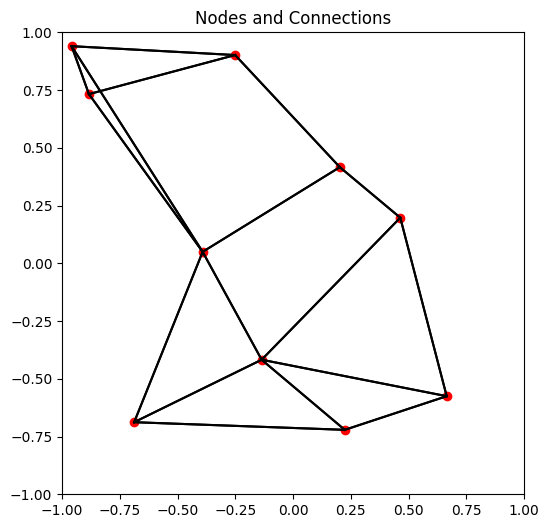

In [19]:
plt.figure(figsize=(6, 6))

# Plotting the points
plt.scatter(nodes_vec[:, 0], nodes_vec[:, 1], color="red")

# Drawing lines between connected nodes
for i in range(len(nodes_vec)):
    for j in range(len(nodes_vec)):
        # If nodes i and j are connected
        if connection_mat[i, j] == 1:
            # Draw a line between them
            plt.plot(
                [nodes_vec[i, 0], nodes_vec[j, 0]],
                [nodes_vec[i, 1], nodes_vec[j, 1]],
                color="black",
            )

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Nodes and Connections")
plt.show()

Define the resistance matrix as the distance matrix, but replace the value of an element by zero if the nodes are connected

In [20]:
# Start with a copy of the distance matrix
resistance_mat = dist_matrix.copy()

# For each element in the connection matrix
for i in range(connection_mat.shape[0]):
    for j in range(connection_mat.shape[1]):
        # If the nodes are connected, set the corresponding resistance to 10^6
        if connection_mat[i][j] == 0:
            resistance_mat[i][j] = 0
        else:
            resistance_mat[i][j] =  dist_matrix[i][j]

# Print the resistance matrix (Latex style)
sy_resistance_mat = sy.Matrix(np.round(resistance_mat, 3))
print("The resistance Matrix is")
sy_resistance_mat

The resistance Matrix is


⎡  0      0      0    0.655  0.664  0.709    0      0      0      0  ⎤
⎢                                                                    ⎥
⎢  0      0      0      0    0.341    0    0.798    0    0.859    0  ⎥
⎢                                                                    ⎥
⎢  0      0      0      0      0      0      0    0.795  0.615  0.912⎥
⎢                                                                    ⎥
⎢0.655    0      0      0      0    0.221    0    0.842    0      0  ⎥
⎢                                                                    ⎥
⎢0.664  0.341    0      0      0      0      0    0.698    0      0  ⎥
⎢                                                                    ⎥
⎢0.709    0      0    0.221    0      0      0    1.056    0      0  ⎥
⎢                                                                    ⎥
⎢  0    0.798    0      0      0      0      0      0    0.816  0.465⎥
⎢                                                                    ⎥
⎢  0  

We now define which nodes are pressure defined, and what are the initial pressures in all other nodes.

In [21]:
Node_IS_BC = np.zeros(len(nodes_vec))
Node_IS_BC[6] = Node_IS_BC[9] = 1
Node_IS_BC[3] = 1
Node_IC_BC = 0.2 * np.ones(len(nodes_vec))
Node_IC_BC[3] = 0
Node_IC_BC[6] = 5
Node_IC_BC[9] = 10

print("Node_IS_BC",Node_IS_BC)
print("Node_IC_BC",Node_IC_BC)

Node_IS_BC [0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
Node_IC_BC [ 0.2  0.2  0.2  0.   0.2  0.2  5.   0.2  0.2 10. ]


Create rigidity vector (currently a linear relation is assumed)

In [22]:
# Initialize the rigidty matrix
rigidity_vec = 100 * np.ones(len(nodes_vec))
print(rigidity_vec)

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


## 5. Numerical solution of the time evolution of pressures in the system

We now define an auxliary function which will later be used within an odeint solver function. This function defines a list of equations to be solved in time for the dynamics of all nodes.

In [25]:
# Define a function to calculate the rate of change of pressures at each node over time.
def pressure_evolv(
    pressuresIn, t, resistance_mat, rigidity_vec, connection_mat, Node_IS_BC, Node_IC_BC
):
    # Initialize an array to store the rates of pressure change for each node.
    d_pressuresIn_dt = np.zeros(pressuresIn.shape)

    # Loop over all nodes.
    for i in range(len(pressuresIn)):
        # If the node is not a boundary condition (BC), i.e., its pressure can change.
        if Node_IS_BC[i] == 0:
            # Loop over all nodes again to check for connections between the current node and others.
            for j in range(len(pressuresIn)):
                # If nodes i and j are connected.
                if connection_mat[i][j] == 1:
                    # Calculate the flow rate between nodes i and j using Ohm's law for fluid flow.
                    q_ij = (pressuresIn[j] - pressuresIn[i]) / resistance_mat[i][j]
                    # Add the contribution of this flow to the rate of pressure change at node i.
                    d_pressuresIn_dt[i] += rigidity_vec[i] * q_ij
        # If the node is a BC, its pressure does not change.
        else:
            d_pressuresIn_dt[i] = 0

    # Return the rates of pressure change at each node.
    return d_pressuresIn_dt

In [26]:
# Define a time vector to solve the ODE over.
t = np.linspace(0, 0.2, 50)
# Solve the system of ODEs using SciPy's odeint function.
pressures = odeint(
    pressure_evolv,
    Node_IC_BC,
    t,
    args=(resistance_mat, rigidity_vec, connection_mat, Node_IS_BC, Node_IC_BC),
)

# Print the pressures matrix (Latex style)
sy_pressures_mat = sy.Matrix(np.round(pressures, 3))
print("The pressures Matrix is")
sy_pressures_mat

The pressures Matrix is


⎡ 0.2    0.2    0.2   0   0.2    0.2   5.0   0.2    0.2   10.0⎤
⎢                                                             ⎥
⎢0.261  2.077  3.634  0  1.03   0.203  5.0  1.624  4.358  10.0⎥
⎢                                                             ⎥
⎢0.615  3.091  5.18   0  2.018  0.423  5.0  2.689  5.349  10.0⎥
⎢                                                             ⎥
⎢0.94   3.687  5.865  0  2.664  0.59   5.0  3.236  5.801  10.0⎥
⎢                                                             ⎥
⎢1.16   4.036  6.192  0  3.051  0.694  5.0  3.526  6.031  10.0⎥
⎢                                                             ⎥
⎢1.294  4.238  6.359  0  3.277  0.755  5.0  3.682  6.154  10.0⎥
⎢                                                             ⎥
⎢1.373  4.353  6.447  0  3.405  0.79   5.0  3.769  6.221  10.0⎥
⎢                                                             ⎥
⎢1.418  4.418  6.495  0  3.479  0.81   5.0  3.817  6.258  10.0⎥
⎢                                       

We can now plot the results, and in order to allow for an interactive plot, we set another auxiliary function

In [28]:
def plot_results(time_step):
    # Create a new figure and axes.
    fig, ax = plt.subplots()

    # Define a range for line widths.
    min_line_width = 0.01
    max_line_width = 3.0

    # Get the maximum and minimum resistance for normalization.
    max_resistance = np.max(resistance_mat)
    min_resistance = np.min(resistance_mat)

    # Loop over all nodes and plot connections between them.
    for i in range(len(nodes_vec)):
        for j in range(i + 1, len(nodes_vec)):
            # If nodes i and j are connected, draw a line between them.
            if connection_mat[i, j] == 1:
                # Normalize resistance value to [0, 1]
                norm_resistance = (resistance_mat[i, j] - min_resistance) / (max_resistance - min_resistance)

                # Calculate line width based on resistance.
                line_width = min_line_width + norm_resistance * (max_line_width - min_line_width)

                ax.plot(
                    [nodes_vec[i, 0], nodes_vec[j, 0]],
                    [nodes_vec[i, 1], nodes_vec[j, 1]],
                    "k-",
                    linewidth=line_width,
                )

    # Create a scatter plot of the nodes, colored by their pressures and sized by their pressures.
    scatter = ax.scatter(
        nodes_vec[:, 0],
        nodes_vec[:, 1],
        c=pressures[time_step],
        s=pressures[time_step] * 100,
        edgecolors="k",
        linewidths=0.5,
    )
    # Add a colorbar to the plot.
    plt.colorbar(scatter, ax=ax, label="Pressure")
    # Set the title of the plot to the current time.
    ax.set_title(f"Time: {t[time_step]}")

    # Display the plot.
    plt.show()


In [29]:
# Create interactive slider
slider = widgets.interact(
    plot_results, time_step=widgets.IntSlider(min=0, max=len(t) - 1, step=1, value=0)
)
display(slider)

interactive(children=(IntSlider(value=0, description='time_step', max=49), Output()), _dom_classes=('widget-in…

<function __main__.plot_results(time_step)>

## 6. Learning phase dynamics


Now we defined the examined configuration, and solved an example case.

We now will use the above functions to recreate the learning mechnism presented in Dillavou *et al.* PRA 2022.

A schematic of the learning mechanism is

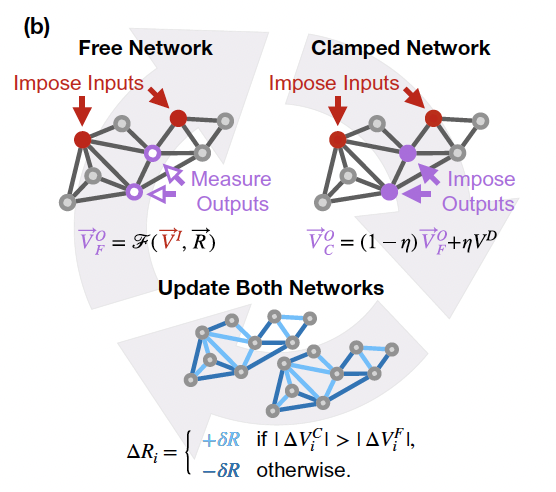

So the following steps
1.   Initialize the free and clampted networks (get first solutions for the given resistance matrix).
2.   Create a loop in which

a. Advance both networks several steps in time

b.  Modify the the resistance matrix at each point



We need to define the boundary conditions for the free and clampted configurations.

In [32]:
# Clampted case
# We initilize the vector
Node_IS_BC_Clamp = np.zeros(len(nodes_vec))
# We set nodes 3, 6 and 9 to be BCs
Node_IS_BC_Clamp[3] = Node_IS_BC_Clamp[6] = Node_IS_BC_Clamp[9] = 1
# Setting initial conditions for all nodes
Node_IC_BC_Clamp = 0.2 * np.ones(len(nodes_vec))
# For the BC nodes the initial conditions is a boundary conditions, and we define it seperatly
Node_IC_BC_Clamp[3] = 0
Node_IC_BC_Clamp[6] = 5
Node_IC_BC_Clamp[9] = 10

print("Node_IS_BC_Clamp",Node_IS_BC_Clamp)
print("Node_IC_BC_Clamp",Node_IC_BC_Clamp)

Node_IS_BC_Clamp [0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
Node_IC_BC_Clamp [ 0.2  0.2  0.2  0.   0.2  0.2  5.   0.2  0.2 10. ]


In [33]:
# Free case
# We initilize the vector
Node_IS_BC_Free = np.zeros(len(nodes_vec))
# We set nodes 3 and 9 to be BCs (node 6 will be the objective in this test)
Node_IS_BC_Free[3] = Node_IS_BC_Free[9] = 1
# Setting initial conditions for all nodes
Node_IC_BC_Free = 0.2 * np.ones(len(nodes_vec))
# For the BC nodes the initial conditions is a boundary conditions, and we define it seperatly
Node_IC_BC_Free[9] = 10
Node_IC_BC_Free[3] = 0

print("Node_IS_BC_Free",Node_IS_BC_Free)
print("Node_IC_BC_Free",Node_IC_BC_Free)

Node_IS_BC_Free [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
Node_IC_BC_Free [ 0.2  0.2  0.2  0.   0.2  0.2  0.2  0.2  0.2 10. ]


In [34]:
  t = np.linspace(0, 0.2, 50)

  pressures_Clamp = odeint(
        pressure_evolv,
        Node_IC_BC_Clamp,
        t,
        args=(resistance_mat, rigidity_vec, connection_mat, Node_IS_BC_Clamp, Node_IC_BC_Clamp),
    )

# Print the pressures matrix (Latex style)
sy_pressuresC_mat = sy.Matrix(np.round(pressures_Clamp, 3))
print("The pressures Matrix is")
sy_pressuresC_mat

The pressures Matrix is


⎡ 0.2    0.2    0.2   0   0.2    0.2   5.0   0.2    0.2   10.0⎤
⎢                                                             ⎥
⎢0.261  2.077  3.634  0  1.03   0.203  5.0  1.624  4.358  10.0⎥
⎢                                                             ⎥
⎢0.615  3.091  5.18   0  2.018  0.423  5.0  2.689  5.349  10.0⎥
⎢                                                             ⎥
⎢0.94   3.687  5.865  0  2.664  0.59   5.0  3.236  5.801  10.0⎥
⎢                                                             ⎥
⎢1.16   4.036  6.192  0  3.051  0.694  5.0  3.526  6.031  10.0⎥
⎢                                                             ⎥
⎢1.294  4.238  6.359  0  3.277  0.755  5.0  3.682  6.154  10.0⎥
⎢                                                             ⎥
⎢1.373  4.353  6.447  0  3.405  0.79   5.0  3.769  6.221  10.0⎥
⎢                                                             ⎥
⎢1.418  4.418  6.495  0  3.479  0.81   5.0  3.817  6.258  10.0⎥
⎢                                       

We now solve the initilized free case

In [35]:
# Solve the system of ODEs using SciPy's odeint function for clamped pressures.
pressures_Free = odeint(pressure_evolv,  Node_IC_BC_Free,t,
                         args=(resistance_mat, rigidity_vec, connection_mat, Node_IS_BC_Free, Node_IC_BC_Free))
# Print the pressures matrix (Latex style)
sy_pressuresF_mat = sy.Matrix(np.round(pressures_Free, 3))
print("The pressures Matrix is")
sy_pressuresF_mat


The pressures Matrix is


⎡ 0.2    0.2    0.2   0   0.2    0.2    0.2    0.2    0.2   10.0⎤
⎢                                                               ⎥
⎢0.21   1.681  3.503  0  0.796  0.182  4.931  1.484  4.112  10.0⎥
⎢                                                               ⎥
⎢0.554  3.19   5.127  0  1.935  0.398  6.449  2.636  5.466  10.0⎥
⎢                                                               ⎥
⎢0.953  4.207  5.962  0  2.845  0.594  7.152  3.343  6.182  10.0⎥
⎢                                                               ⎥
⎢1.265  4.866  6.428  0  3.467  0.737  7.55   3.777   6.6   10.0⎥
⎢                                                               ⎥
⎢1.481  5.287  6.703  0  3.873  0.832  7.792  4.046  6.854  10.0⎥
⎢                                                               ⎥
⎢1.623  5.555  6.871  0  4.133  0.894  7.944  4.215  7.013  10.0⎥
⎢                                                               ⎥
⎢1.714  5.726  6.975  0  4.299  0.934  8.04   4.322  7.112  10.0⎥
⎢         

Let's solve the Free and Clampted networks

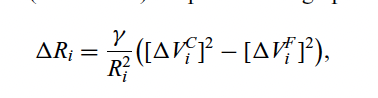

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

Node_IC_BC_Clamp_Out = 5
eta = 0.05
t = np.linspace(0, 0.1, 10)
gamma = 10
resistance_mat_new = resistance_mat.copy()

Node_IC_BC_Free_new = pressures_Free[-1]
Node_IC_BC_Clamp_new = pressures_Clamp[-1]

pressures_Free_List = []
pressures_Clamp_List = []
Node_IC_BC_Clamp_Out_List = []
delta_list = []
min_resistance_list = []
max_resistance_list = []

for iteration in range(100):
    pressures_Free = odeint(
        pressure_evolv,
        Node_IC_BC_Free_new,
        t,
        args=(resistance_mat_new, rigidity_vec, connection_mat, Node_IS_BC_Free, Node_IC_BC_Free_new),
    )
    Node_IC_BC_Clamp_new[6] = eta * Node_IC_BC_Clamp_Out + (1 - eta) * pressures_Free[-1][6]
    pressures_Clamp = odeint(
        pressure_evolv,
        Node_IC_BC_Clamp_new,
        t,
        args=(resistance_mat_new, rigidity_vec, connection_mat, Node_IS_BC_Clamp, Node_IC_BC_Clamp_new),
    )
    Node_IC_BC_Clamp_new = pressures_Clamp[-1]

    for i in range(len(nodes_vec)):
        for j in range(i + 1, len(nodes_vec)):
            if connection_mat[i][j] == 1:
                delta = (gamma / (resistance_mat_new[i][j] ** 2)) * (
                    (pressures_Clamp[-1][i] - pressures_Clamp[-1][j]) ** 2 -
                    (pressures_Free[-1][i] - pressures_Free[-1][j]) ** 2
                )
                deltaV=0.03 if resistance_mat_new[i][j] + delta > 0.1 else -0.03
                resistance_mat_new[i][j] = resistance_mat_new[i][j] + deltaV
                resistance_mat_new[j][i] = resistance_mat_new[j][i] + deltaV

    pressures_Free_List.append(pressures_Free[-1,6])
    pressures_Clamp_List.append(pressures_Clamp[-1,6])
    Node_IC_BC_Clamp_Out_List.append(Node_IC_BC_Clamp_Out)
    delta_list.append(delta)
    min_resistance_list.append(np.min(resistance_mat_new))
    max_resistance_list.append(np.max(resistance_mat_new))

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12,10))

# Plot pressures in the first subplot
axs[0, 0].plot(range(100), pressures_Free_List, label='Pressures Free')
axs[0, 0].plot(range(100), pressures_Clamp_List, label='Pressures Clamp')
axs[0, 0].plot(range(100), Node_IC_BC_Clamp_Out_List, label='Node IC BC Clamp Out')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Pressure Value')
axs[0, 0].set_title('Convergence of the Model')
axs[0, 0].legend()

# Plot delta in the second subplot
axs[0, 1].plot(range(100), delta_list, label='Delta', color='r')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Delta Value')
axs[0, 1].set_title('Delta Analysis')
axs[0, 1].legend()

# Plot min resistance in the third subplot
axs[1, 0].plot(range(100), min_resistance_list, label='Min Resistance', color='g')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Min Resistance Value')
axs[1, 0].set_title('Min Resistance Analysis')
axs[1, 0].legend()

# Plot max resistance in the fourth subplot
axs[1, 1].plot(range(100), max_resistance_list, label='Max Resistance', color='b')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Max Resistance Value')
axs[1, 1].set_title('Max Resistance Analysis')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-36-4b61d3804243>:42: RuntimeWarning: overflow encountered in double_scalars
  (pressures_Free[-1][i] - pressures_Free[-1][j]) ** 2
<ipython-input-36-4b61d3804243>:41: RuntimeWarning: overflow encountered in double_scalars
  (pressures_Clamp[-1][i] - pressures_Clamp[-1][j]) ** 2 -
<ipython-input-36-4b61d3804243>:41: RuntimeWarning: invalid value encountered in double_scalars
  (pressures_Clamp[-1][i] - pressures_Clamp[-1][j]) ** 2 -
<ipython-input-25-86f8f76341e7>:19: RuntimeWarning: overflow enco

KeyboardInterrupt: ignored

# Yossi's calc section